# URL
https://github.com/oreilly-japan/deep-learning-from-scratch

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# 外部のものを使用

In [2]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

In [3]:
def softmax(x):
    x = x - np.max(x, axis=-1, keepdims=True)   # オーバーフロー対策
    return np.exp(x) / np.sum(np.exp(x), axis=-1, keepdims=True)

In [4]:
def numerical_gradient(f, x):
    h = 1e-4 # 0.0001
    grad = np.zeros_like(x)
    
    it = np.nditer(x, flags=['multi_index'], op_flags=['readwrite'])
    while not it.finished:
        idx = it.multi_index
        tmp_val = x[idx]
        x[idx] = tmp_val + h
        fxh1 = f(x) # f(x+h)
        
        x[idx] = tmp_val - h 
        fxh2 = f(x) # f(x-h)
        grad[idx] = (fxh1 - fxh2) / (2*h)
        
        x[idx] = tmp_val # 値を元に戻す
        it.iternext()   
        
    return grad

In [5]:
def _numerical_gradient_no_batch(f, x):
    h = 1e-4  # 0.0001
    grad = np.zeros_like(x)
    
    for idx in range(x.size):
        tmp_val = x[idx]
        x[idx] = float(tmp_val) + h
        fxh1 = f(x)  # f(x+h)
        
        x[idx] = tmp_val - h 
        fxh2 = f(x)  # f(x-h)
        grad[idx] = (fxh1 - fxh2) / (2*h)
        
        x[idx] = tmp_val  # 値を元に戻す
        
    return grad

In [6]:
def cross_entropy_error(y, t):
    if y.ndim == 1:
        t = t.reshape(1, t.size)
        y = y.reshape(1, y.size)
        
    # 教師データがone-hot-vectorの場合、正解ラベルのインデックスに変換
    if t.size == y.size:
        t = t.argmax(axis=1)
             
    batch_size = y.shape[0]
    return -np.sum(np.log(y[np.arange(batch_size), t] + 1e-7)) / batch_size


# ２層ニューラルネットワーク

In [7]:
class TwoLayerNet:

    def __init__(self, input_size, hidden_size, output_size, weight_init_std=0.01):
        """
        input_size: 入力層のニューロンの数
        hidden_size: 隠れ層のニューロンの数
        output_size: 出力層のニューロンの数
        """
        # 重みの初期化
        self.params = {}   # ニューラルネットワークのパラメータを保持するディクショナリ変数。（インスタンス変数）
        self.params['W1'] = weight_init_std * np.random.randn(input_size, hidden_size)   # 1層目の重み
        self.params['b1'] = np.zeros(hidden_size)   # 1層目のバイアス
        self.params['W2'] = weight_init_std * np.random.randn(hidden_size, output_size)   # 2層目の重み
        self.params['b2'] = np.zeros(output_size)   # 2層目のバイアス

    def predict(self, x):
        """
        推論を行う
        x: 画像データ
        """
        W1, W2 = self.params['W1'], self.params['W2']
        b1, b2 = self.params['b1'], self.params['b2']
    
        a1 = np.dot(x, W1) + b1
        z1 = sigmoid(a1)
        a2 = np.dot(z1, W2) + b2
        y = softmax(a2)
        
        return y
        
    # x:入力データ, t:教師データ
    def loss(self, x, t):
        """
        損失関数の値を求める
        x: 画像データ
        t: 正解ラベル
        """
        y = self.predict(x)
        
        return cross_entropy_error(y, t)
    
    def accuracy(self, x, t):
        """
        認識精度を求める。
        x: 画像データ
        t: 正解ラベル
        """
        y = self.predict(x)
        y = np.argmax(y, axis=1)
        t = np.argmax(t, axis=1)
        
        accuracy = np.sum(y == t) / float(x.shape[0])
        return accuracy
        
    # x:入力データ, t:教師データ
    def numerical_gradient(self, x, t):
        """
        重みパラメータに対する勾配を求める。
        x: 画像データ
        t: 正解ラベル
        """
        loss_W = lambda W: self.loss(x, t)
        
        grads = {}
        grads['W1'] = numerical_gradient(loss_W, self.params['W1'])   # 1層目の重みの勾配
        grads['b1'] = numerical_gradient(loss_W, self.params['b1'])   # 1層目のバイアスの勾配
        grads['W2'] = numerical_gradient(loss_W, self.params['W2'])   # 2層目の重みの勾配
        grads['b2'] = numerical_gradient(loss_W, self.params['b2'])   # 2層目のバイアスの勾配
        
        return grads
        
    def gradient(self, x, t):
        """
        重みパラメータに対する勾配を求める。
        numerical_gradient()の高速版。
        x: 画像データ
        t: 正解ラベル
        """
        W1, W2 = self.params['W1'], self.params['W2']
        b1, b2 = self.params['b1'], self.params['b2']
        grads = {}   # 勾配を保持するディクショナリ変数。（numerical_gradient()メソッドの返り値）
        
        batch_num = x.shape[0]
        
        # forward
        a1 = np.dot(x, W1) + b1
        z1 = sigmoid(a1)
        a2 = np.dot(z1, W2) + b2
        y = softmax(a2)
        
        # backward
        dy = (y - t) / batch_num
        grads['W2'] = np.dot(z1.T, dy)
        grads['b2'] = np.sum(dy, axis=0)
        
        dz1 = np.dot(dy, W2.T)
        da1 = sigmoid_grad(a1) * dz1
        grads['W1'] = np.dot(x.T, da1)
        grads['b1'] = np.sum(da1, axis=0)

        return grads

In [8]:
net = TwoLayerNet(input_size=784, hidden_size=100, output_size=10)
print(f"W1.shape: {net.params['W1'].shape}")
print(f"b1.shape: {net.params['b1'].shape}")
print(f"W2.shape: {net.params['W2'].shape}")
print(f"b2.shape: {net.params['b2'].shape}")

W1.shape: (784, 100)
b1.shape: (100,)
W2.shape: (100, 10)
b2.shape: (10,)


In [9]:
x = np.random.rand(100, 784)
y = net.predict(x)

In [10]:
x = np.random.rand(100, 784)   # ダミーの入力データ
t = np.random.rand(100, 10)   # ダミーの正解ラベル

grads = net.numerical_gradient(x, t)   # 勾配を計算
print(f"W1.shape: {grads['W1'].shape}")
print(f"b1.shape: {grads['b1'].shape}")
print(f"W2.shape: {grads['W2'].shape}")
print(f"b2.shape: {grads['b2'].shape}")

W1.shape: (784, 100)
b1.shape: (100,)
W2.shape: (100, 10)
b2.shape: (10,)


# 乗算レイヤ

In [11]:
class MulLayer:
    def __init__(self):
        self.x = None
        self.y = None

    def forward(self, x, y):
        self.x = x
        self.y = y                
        out = x * y

        return out

    def backward(self, dout):
        dx = dout * self.y
        dy = dout * self.x

        return dx, dy

In [12]:
apple = 100
apple_num = 2
tax = 1.1

mul_apple_layer = MulLayer()
mul_tax_layer = MulLayer()

# forward
apple_price = mul_apple_layer.forward(apple, apple_num)
price = mul_tax_layer.forward(apple_price, tax)

# backward
dprice = 1
dapple_price, dtax = mul_tax_layer.backward(dprice)
dapple, dapple_num = mul_apple_layer.backward(dapple_price)

print("price:", int(price))
print("dApple:", dapple)
print("dApple_num:", int(dapple_num))
print("dTax:", dtax)

price: 220
dApple: 2.2
dApple_num: 110
dTax: 200


# 加算レイヤ

In [13]:
class AddLayer:
    def __init__(self):
        pass

    def forward(self, x, y):
        out = x + y

        return out

    def backward(self, dout):
        dx = dout * 1
        dy = dout * 1

        return dx, dy

In [14]:
apple = 100
apple_num = 2
orange = 150
orange_num = 3
tax = 1.1

# layer
mul_apple_layer = MulLayer()
mul_orange_layer = MulLayer()
add_apple_orange_layer = AddLayer()
mul_tax_layer = MulLayer()

# forward
apple_price = mul_apple_layer.forward(apple, apple_num)  # (1)
orange_price = mul_orange_layer.forward(orange, orange_num)  # (2)
all_price = add_apple_orange_layer.forward(apple_price, orange_price)  # (3)
price = mul_tax_layer.forward(all_price, tax)  # (4)

# backward
dprice = 1
dall_price, dtax = mul_tax_layer.backward(dprice)  # (4)
dapple_price, dorange_price = add_apple_orange_layer.backward(dall_price)  # (3)
dorange, dorange_num = mul_orange_layer.backward(dorange_price)  # (2)
dapple, dapple_num = mul_apple_layer.backward(dapple_price)  # (1)

print("price:", int(price))
print("dApple:", dapple)
print("dApple_num:", int(dapple_num))
print("dOrange:", dorange)
print("dOrange_num:", int(dorange_num))
print("dTax:", dtax)

price: 715
dApple: 2.2
dApple_num: 110
dOrange: 3.3000000000000003
dOrange_num: 165
dTax: 650


# 誤差逆伝播法に対応したニューラルネットワーク

In [15]:
class TwoLayerNet:

    def __init__(self, input_size, hidden_size, output_size, weight_init_std = 0.01):
        # 重みの初期化
        self.params = {}
        self.params['W1'] = weight_init_std * np.random.randn(input_size, hidden_size)
        self.params['b1'] = np.zeros(hidden_size)
        self.params['W2'] = weight_init_std * np.random.randn(hidden_size, output_size) 
        self.params['b2'] = np.zeros(output_size)

        # レイヤの生成
        self.layers = OrderedDict()   # 順番付きディクショナリ。追加した要素の順番を覚えている。追加した順にレイヤのforward()メソッドを呼び出すだけで処理が完了。
        self.layers['Affine1'] = Affine(self.params['W1'], self.params['b1'])
        self.layers['Relu1'] = Relu()
        self.layers['Affine2'] = Affine(self.params['W2'], self.params['b2'])

        self.lastLayer = SoftmaxWithLoss()
        
    def predict(self, x):
        for layer in self.layers.values():
            x = layer.forward(x)
        
        return x
        
    # x:入力データ, t:教師データ
    def loss(self, x, t):
        y = self.predict(x)
        return self.lastLayer.forward(y, t)
    
    def accuracy(self, x, t):
        y = self.predict(x)
        y = np.argmax(y, axis=1)
        if t.ndim != 1 : t = np.argmax(t, axis=1)
        
        accuracy = np.sum(y == t) / float(x.shape[0])
        return accuracy
        
    # x:入力データ, t:教師データ
    def numerical_gradient(self, x, t):
        loss_W = lambda W: self.loss(x, t)
        
        grads = {}
        grads['W1'] = numerical_gradient(loss_W, self.params['W1'])
        grads['b1'] = numerical_gradient(loss_W, self.params['b1'])
        grads['W2'] = numerical_gradient(loss_W, self.params['W2'])
        grads['b2'] = numerical_gradient(loss_W, self.params['b2'])
        
        return grads
        
    def gradient(self, x, t):
        # forward
        self.loss(x, t)

        # backward
        dout = 1
        dout = self.lastLayer.backward(dout)
        
        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)

        # 設定
        grads = {}
        grads['W1'], grads['b1'] = self.layers['Affine1'].dW, self.layers['Affine1'].db
        grads['W2'], grads['b2'] = self.layers['Affine2'].dW, self.layers['Affine2'].db

        return grads

# 最適化

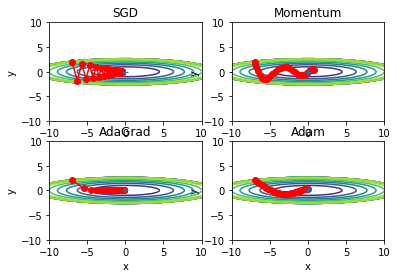

In [16]:
from collections import OrderedDict

class SGD:

    """確率的勾配降下法（Stochastic Gradient Descent）"""

    def __init__(self, lr=0.01):
        self.lr = lr
        
    def update(self, params, grads):
        for key in params.keys():
            params[key] -= self.lr * grads[key] 


class Momentum:

    """Momentum SGD"""

    def __init__(self, lr=0.01, momentum=0.9):
        self.lr = lr
        self.momentum = momentum
        self.v = None
        
    def update(self, params, grads):
        if self.v is None:
            self.v = {}
            for key, val in params.items():                                
                self.v[key] = np.zeros_like(val)
                
        for key in params.keys():
            self.v[key] = self.momentum*self.v[key] - self.lr*grads[key] 
            params[key] += self.v[key]


class Nesterov:

    """Nesterov's Accelerated Gradient (http://arxiv.org/abs/1212.0901)"""

    def __init__(self, lr=0.01, momentum=0.9):
        self.lr = lr
        self.momentum = momentum
        self.v = None
        
    def update(self, params, grads):
        if self.v is None:
            self.v = {}
            for key, val in params.items():
                self.v[key] = np.zeros_like(val)
            
        for key in params.keys():
            params[key] += self.momentum * self.momentum * self.v[key]
            params[key] -= (1 + self.momentum) * self.lr * grads[key]
            self.v[key] *= self.momentum
            self.v[key] -= self.lr * grads[key]


class AdaGrad:

    """AdaGrad"""

    def __init__(self, lr=0.01):
        self.lr = lr
        self.h = None
        
    def update(self, params, grads):
        if self.h is None:
            self.h = {}
            for key, val in params.items():
                self.h[key] = np.zeros_like(val)
            
        for key in params.keys():
            self.h[key] += grads[key] * grads[key]
            params[key] -= self.lr * grads[key] / (np.sqrt(self.h[key]) + 1e-7)


class RMSprop:

    """RMSprop"""

    def __init__(self, lr=0.01, decay_rate = 0.99):
        self.lr = lr
        self.decay_rate = decay_rate
        self.h = None
        
    def update(self, params, grads):
        if self.h is None:
            self.h = {}
            for key, val in params.items():
                self.h[key] = np.zeros_like(val)
            
        for key in params.keys():
            self.h[key] *= self.decay_rate
            self.h[key] += (1 - self.decay_rate) * grads[key] * grads[key]
            params[key] -= self.lr * grads[key] / (np.sqrt(self.h[key]) + 1e-7)


class Adam:

    """Adam (http://arxiv.org/abs/1412.6980v8)"""

    def __init__(self, lr=0.001, beta1=0.9, beta2=0.999):
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.iter = 0
        self.m = None
        self.v = None
        
    def update(self, params, grads):
        if self.m is None:
            self.m, self.v = {}, {}
            for key, val in params.items():
                self.m[key] = np.zeros_like(val)
                self.v[key] = np.zeros_like(val)
        
        self.iter += 1
        lr_t  = self.lr * np.sqrt(1.0 - self.beta2**self.iter) / (1.0 - self.beta1**self.iter)         
        
        for key in params.keys():
            #self.m[key] = self.beta1*self.m[key] + (1-self.beta1)*grads[key]
            #self.v[key] = self.beta2*self.v[key] + (1-self.beta2)*(grads[key]**2)
            self.m[key] += (1 - self.beta1) * (grads[key] - self.m[key])
            self.v[key] += (1 - self.beta2) * (grads[key]**2 - self.v[key])
            
            params[key] -= lr_t * self.m[key] / (np.sqrt(self.v[key]) + 1e-7)
            
            #unbias_m += (1 - self.beta1) * (grads[key] - self.m[key]) # correct bias
            #unbisa_b += (1 - self.beta2) * (grads[key]*grads[key] - self.v[key]) # correct bias
            #params[key] += self.lr * unbias_m / (np.sqrt(unbisa_b) + 1e-7)

def f(x, y):
    return x**2 / 20.0 + y**2


def df(x, y):
    return x / 10.0, 2.0*y

init_pos = (-7.0, 2.0)
params = {}
params['x'], params['y'] = init_pos[0], init_pos[1]
grads = {}
grads['x'], grads['y'] = 0, 0


optimizers = OrderedDict()
optimizers["SGD"] = SGD(lr=0.95)
optimizers["Momentum"] = Momentum(lr=0.1)
optimizers["AdaGrad"] = AdaGrad(lr=1.5)
optimizers["Adam"] = Adam(lr=0.3)

idx = 1

for key in optimizers:
    optimizer = optimizers[key]
    x_history = []
    y_history = []
    params['x'], params['y'] = init_pos[0], init_pos[1]
    
    for i in range(30):
        x_history.append(params['x'])
        y_history.append(params['y'])
        
        grads['x'], grads['y'] = df(params['x'], params['y'])
        optimizer.update(params, grads)
    

    x = np.arange(-10, 10, 0.01)
    y = np.arange(-5, 5, 0.01)
    
    X, Y = np.meshgrid(x, y) 
    Z = f(X, Y)
    
    # for simple contour line  
    mask = Z > 7
    Z[mask] = 0
    
    # plot 
    plt.subplot(2, 2, idx)
    idx += 1
    plt.plot(x_history, y_history, 'o-', color="red")
    plt.contour(X, Y, Z)
    plt.ylim(-10, 10)
    plt.xlim(-10, 10)
    plt.plot(0, 0, '+')
    #colorbar()
    #spring()
    plt.title(key)
    plt.xlabel("x")
    plt.ylabel("y")
    
plt.show()